In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import D3Blocks

ModuleNotFoundError: No module named 'd3blocks'

In [ ]:
# Parameters
total_years = 20
dt = 1/10
time = np.arange(0, total_years, dt)
n = len(time)
nc_per_year = 10
#this value will be different that just the new construction percent (each competition group will have to adjust by a different growth rate)
# do we have the information to make a certain assumptions (currently already making this assumption but done by sales disagg)

nc = nc_per_year * dt 
nc_arr = np.full(n, nc)  # Create an array of 10s for plotting

# Initialize arrays
total_stock = np.zeros(n)
ret_stock = np.zeros(n)
md_stock = np.zeros(n)
# Substocks within ret_stock
ret_below_baseline_stock = np.zeros(n)
ret_baseline_stock = np.zeros(n)
ret_efficient_stock = np.zeros(n)
# Substocks within md_stock
md_below_baseline_stock = np.zeros(n)
md_baseline_stock = np.zeros(n)
md_efficient_stock = np.zeros(n)
# Create an array of cumulative annual totals for nc
nc_cumulative_annual = np.zeros(n)

# Initial conditions
total_stock[0] = 1000
ret_stock[0] = total_stock[0] * 0.9
md_stock[0] = total_stock[0] * 0.09 #we need to see where this .01 of the population goes


# Initial conditions for ret substocks
ret_below_baseline_stock[0] = ret_stock[0] * 0.2
ret_baseline_stock[0] = ret_stock[0] * 0.6
ret_efficient_stock[0] = ret_stock[0] * 0.2

#we need to refine the retrofit stock to be just those that are actually - 
# simpler cannot be unmamagable to characterize (capture intent of early retirements)
# discintion between add on and early
# early retirements might be done differently then Ret Add on - 
# add on Measure we can do whenever (time invarient)
# eary retirement replacement assumption implicent assumption that the equipment is already a certain age - 2/3 rule of thumb
# we currently allow 100 % possible but we should probabily limit it to 2/3 is we are limiting savings already (Oldest third of stock)
#low penetration rates might be saving us now


# Initial conditions for md substocks
md_below_baseline_stock[0] = md_stock[0] * 0.2
md_baseline_stock[0] = md_stock[0] * 0.6
md_efficient_stock[0] = md_stock[0] * 0.2

In [41]:
md_retirement_rate = 1
ret_retirement_rate = 0.02
# Market sizes for each segment
m_ret = ret_stock[0]
m_md = md_stock[0]

# Initialize cumulative adopters for each market
ret_cumulative_adopters = np.zeros(n)
md_cumulative_adopters = np.zeros(n)
ret_cumulative_adopters[0] = ret_efficient_stock[0]
md_cumulative_adopters[0] = md_efficient_stock[0]

In [42]:
def tech_eq(Below_Baseline, Baseline, Efficient, m, retirement_rate):
    tech_value = 1
    tech_share = np.clip(tech_value, 0.0, 1.0)
    Retirement_Flow = m * retirement_rate
    Efficient_Adoption_Flow = Retirement_Flow * tech_share 
    Remaining_Flow = Retirement_Flow - Efficient_Adoption_Flow
    Baseline_Adoption_Flow = Remaining_Flow # should be zero as this is technical but left in for future
    Below_Baseline_Adoption_Flow = 0.0
    
    dEfficient_dt = Efficient_Adoption_Flow - (Efficient * retirement_rate)
    dBaseline_dt = Baseline_Adoption_Flow - (Baseline * retirement_rate)
    dBelow_Baseline_dt = Below_Baseline_Adoption_Flow - (Below_Baseline * retirement_rate)
    
    return dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt

In [43]:
for t in range(1, n):
    # Add new construction to total stock
    total_stock[t] = total_stock[t-1] + nc

    # --- Apply Tech to RETROFIT MARKET ---
    dBB_ret, dB_ret, dE_ret = tech_eq(
        ret_below_baseline_stock[t-1],
        ret_baseline_stock[t-1],
        ret_efficient_stock[t-1],
        ret_stock[t-1],
        ret_retirement_rate
    )
    temp_ret_below_baseline = max(ret_below_baseline_stock[t-1] + dBB_ret * dt, 0.0)
    temp_ret_baseline = max(ret_baseline_stock[t-1] + dB_ret * dt, 0.0)
    temp_ret_efficient = max(ret_efficient_stock[t-1] + dE_ret * dt, 0.0)

    # --- Apply Tech to MARKET DRIVEN MARKET ---
    dBB_md, dB_md, dE_md = tech_eq(
        md_below_baseline_stock[t-1],
        md_baseline_stock[t-1],
        md_efficient_stock[t-1],
        md_stock[t-1],
        md_retirement_rate
    )
    temp_md_below_baseline = max(md_below_baseline_stock[t-1] + dBB_md * dt, 0.0)
    temp_md_baseline = max(md_baseline_stock[t-1] + dB_md * dt, 0.0)
    temp_md_efficient = max(md_efficient_stock[t-1] + dE_md * dt, 0.0)

    # --- Move stocks between markets ---
    # 1/10th of ret_stock substocks become md_stock, all md_stock substocks move to ret_stock
    new_md_below_baseline_stock = temp_ret_below_baseline * 0.1
    new_ret_below_baseline_stock = (temp_ret_below_baseline * 0.9) + temp_md_below_baseline

    new_md_baseline_stock = temp_ret_baseline * 0.1
    new_ret_baseline_stock = (temp_ret_baseline * 0.9) + temp_md_baseline

    new_md_efficient_stock = temp_ret_efficient * 0.1
    new_ret_efficient_stock = (temp_ret_efficient * 0.9) + temp_md_efficient

    # --- Add new construction to ret_stock substocks ---
    ret_below_baseline_stock[t] = new_ret_below_baseline_stock + (nc * 0) #proportioning nc here but should make this an input
    ret_baseline_stock[t] = new_ret_baseline_stock + (nc * 0.5)
    ret_efficient_stock[t] = new_ret_efficient_stock + (nc * 0.5)

    md_below_baseline_stock[t] = new_md_below_baseline_stock
    md_baseline_stock[t] = new_md_baseline_stock
    md_efficient_stock[t] = new_md_efficient_stock

    # --- Update market totals ---
    ret_stock[t] = ret_below_baseline_stock[t] + ret_baseline_stock[t] + ret_efficient_stock[t]
    md_stock[t] = md_below_baseline_stock[t] + md_baseline_stock[t] + md_efficient_stock[t]
    total_stock[t] = ret_stock[t] + md_stock[t]

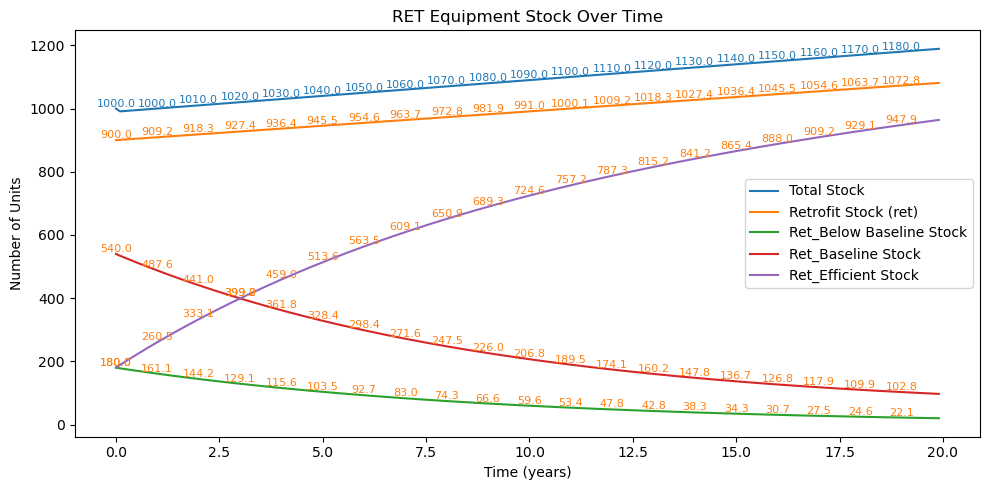

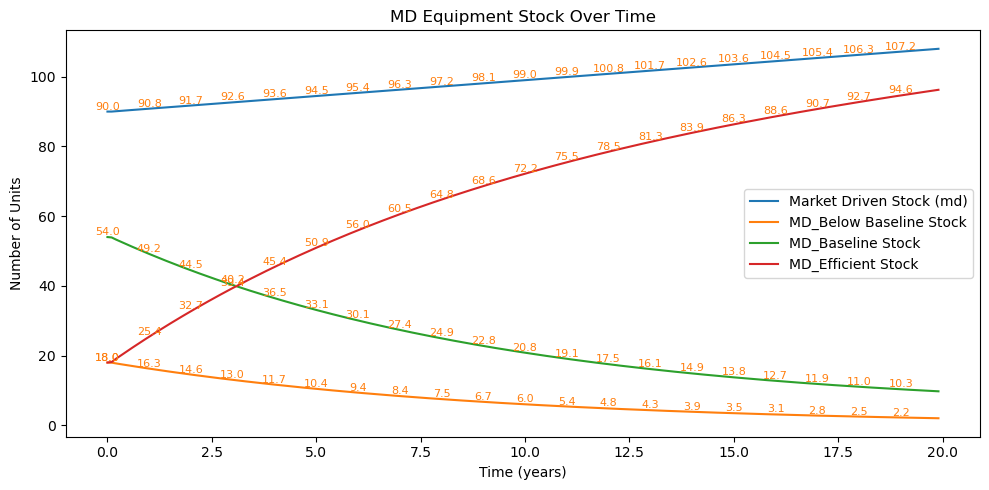

In [44]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time, total_stock, label="Total Stock")
plt.plot(time, ret_stock, label="Retrofit Stock (ret)")
# plt.plot(time, md_stock, label="Market Driven Stock (md)")
# plt.plot(time, nc_arr, label="New Construction Distrupter (nc)")
# plt.plot(time, nc_cumulative_total, label="Cumulative Annual New Construction (nc)")
plt.plot(time, ret_below_baseline_stock, label="Ret_Below Baseline Stock")
plt.plot(time, ret_baseline_stock, label="Ret_Baseline Stock")
plt.plot(time, ret_efficient_stock, label="Ret_Efficient Stock")
for i in range(0, len(time), 10):
    plt.text(time[i], total_stock[i], f"{total_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
    # plt.text(time[i], md_stock[i], f"{md_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], ret_stock[i], f"{ret_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], ret_below_baseline_stock[i], f"{ret_below_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], ret_baseline_stock[i], f"{ret_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], ret_efficient_stock[i], f"{ret_efficient_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    # plt.text(time[i], nc_arr[i], f"{nc_arr[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
    # plt.text(time[i], nc_cumulative_total[i], f"{nc_cumulative_total[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("RET Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Plotting
plt.figure(figsize=(10, 5))
#plt.plot(time, total_stock, label="Total Stock")
plt.plot(time, md_stock, label="Market Driven Stock (md)")
# plt.plot(time, nc_arr, label="New Construction Distrupter (nc)")
# plt.plot(time, nc_cumulative_total, label="Cumulative Annual New Construction (nc)")
plt.plot(time, md_below_baseline_stock, label="MD_Below Baseline Stock")
plt.plot(time, md_baseline_stock, label="MD_Baseline Stock")
plt.plot(time, md_efficient_stock, label="MD_Efficient Stock")
for i in range(0, len(time), 10):
   # plt.text(time[i], total_stock[i], f"{total_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:blue')
    # plt.text(time[i], md_stock[i], f"{md_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], md_stock[i], f"{md_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], md_below_baseline_stock[i], f"{md_below_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], md_baseline_stock[i], f"{md_baseline_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], md_efficient_stock[i], f"{md_efficient_stock[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:orange')
    # plt.text(time[i], nc_arr[i], f"{nc_arr[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:red')
    # plt.text(time[i], nc_cumulative_total[i], f"{nc_cumulative_total[i]:.1f}", fontsize=8, ha='center', va='bottom', color='tab:purple')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("MD Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()